In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-01-01-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-01-01-10.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-02-02-10.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-02-01-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-01-02-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-01-01-02-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-01-02-01-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-01-02-02-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-02-01-01-10.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-01-02-10.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-02-01-02-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-01-01-01-02.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-01-01-02-01-10.wav
/kaggle/input/dataset-imp/clean_wav/clean_wav/03-01-02-01-01-01-10.wav
/kaggl

Setting up environment...
PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB
Processing 20 clean files and 22 noise files


Mixing audio:   0%|          | 0/20 [00:00<?, ?it/s]

Target SNR: -5 dB, Actual SNR: -5.00 dB
Target SNR: 0 dB, Actual SNR: 0.00 dB
Target SNR: 5 dB, Actual SNR: 5.00 dB
Target SNR: 10 dB, Actual SNR: 10.00 dB
Target SNR: -5 dB, Actual SNR: -5.00 dB
Target SNR: 0 dB, Actual SNR: -0.00 dB
Target SNR: 5 dB, Actual SNR: 5.00 dB
Target SNR: 10 dB, Actual SNR: 10.00 dB


Mixing audio:   5%|▌         | 1/20 [00:01<00:28,  1.50s/it]

Target SNR: -5 dB, Actual SNR: -5.00 dB
Target SNR: 0 dB, Actual SNR: -0.00 dB
Target SNR: 5 dB, Actual SNR: 5.00 dB
Target SNR: 10 dB, Actual SNR: 10.00 dB
Target SNR: -5 dB, Actual SNR: -5.00 dB
Target SNR: 0 dB, Actual SNR: 0.00 dB
Target SNR: 5 dB, Actual SNR: 5.00 dB
Target SNR: 10 dB, Actual SNR: 10.00 dB


Mixing audio: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


Mixed files created: 1760


Creating STFT: 100%|██████████| 1760/1760 [00:23<00:00, 75.64it/s]


Dataset: 1408 train, 176 val, 176 test
Epoch 10: Train Loss 0.001769, Val Loss 0.002228
Epoch 20: Train Loss 0.000748, Val Loss 0.000819
Epoch 30: Train Loss 0.000486, Val Loss 0.000769
Saved enhanced audio: /kaggle/working/enhanced_audio/03-01-01-01-01-01-02_ambience_snr-5dB_enhanced.wav

🔹 Sample 1: 03-01-01-01-01-01-02
Input SNR : -26.65 dB
Output SNR: 17.54 dB
SNR Improvement: 44.19 dB


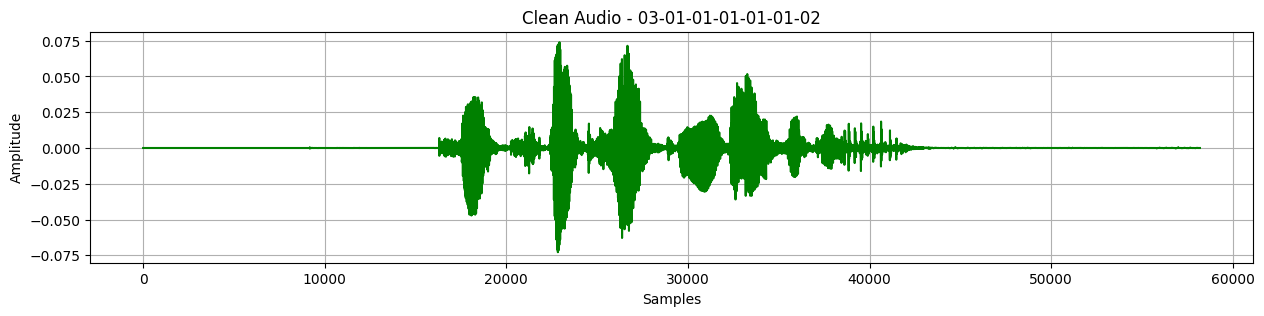

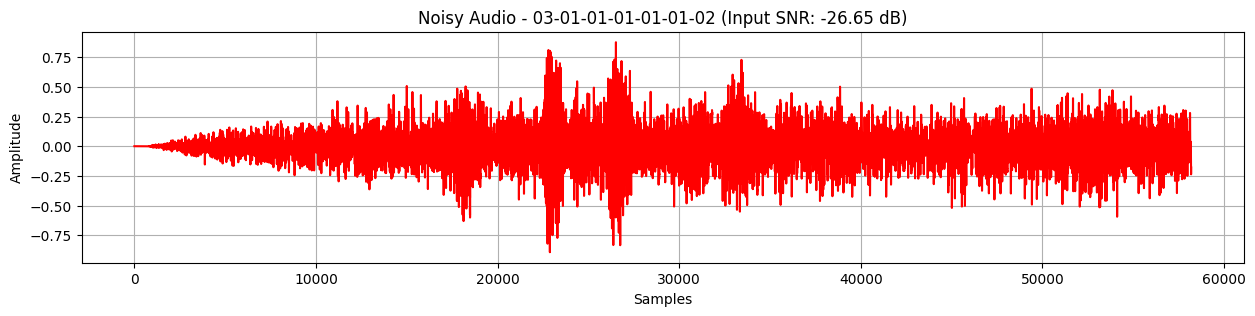

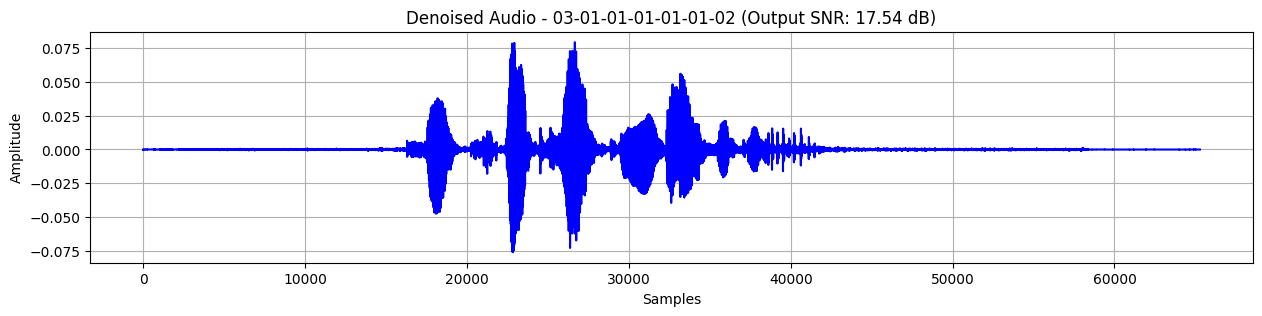

Saved enhanced audio: /kaggle/working/enhanced_audio/03-01-01-01-01-01-02_ambience_snr0dB_enhanced.wav

🔹 Sample 2: 03-01-01-01-01-01-02
Input SNR : -26.65 dB
Output SNR: 17.06 dB
SNR Improvement: 43.71 dB


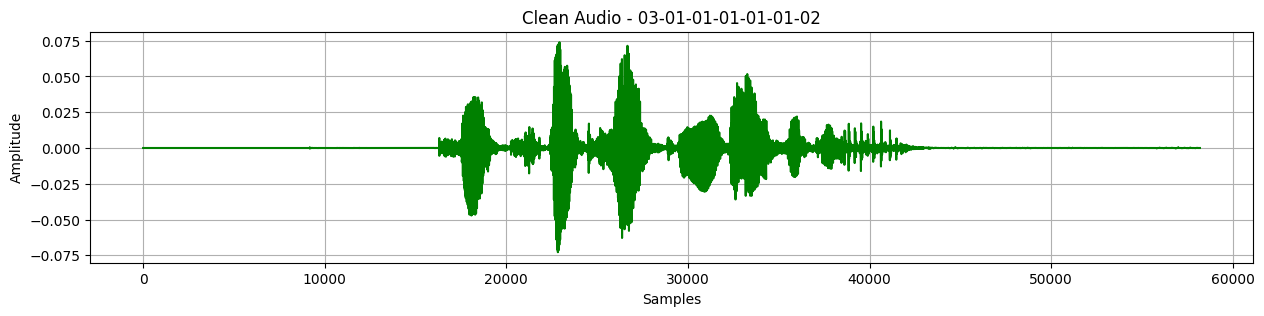

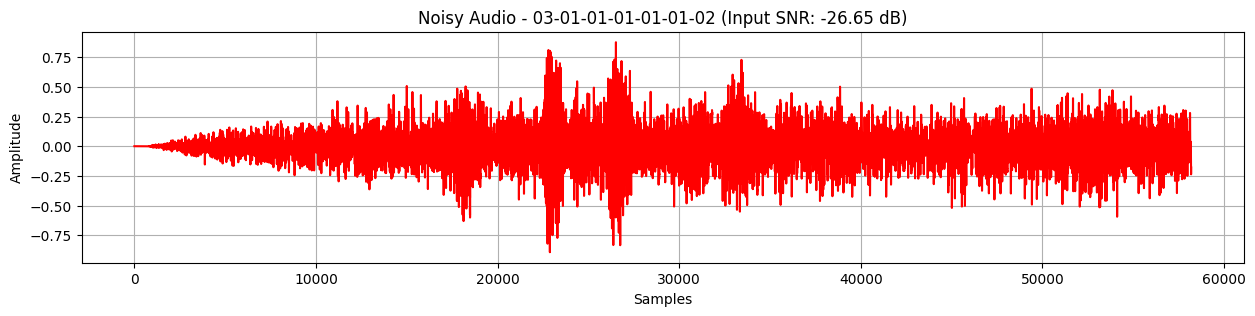

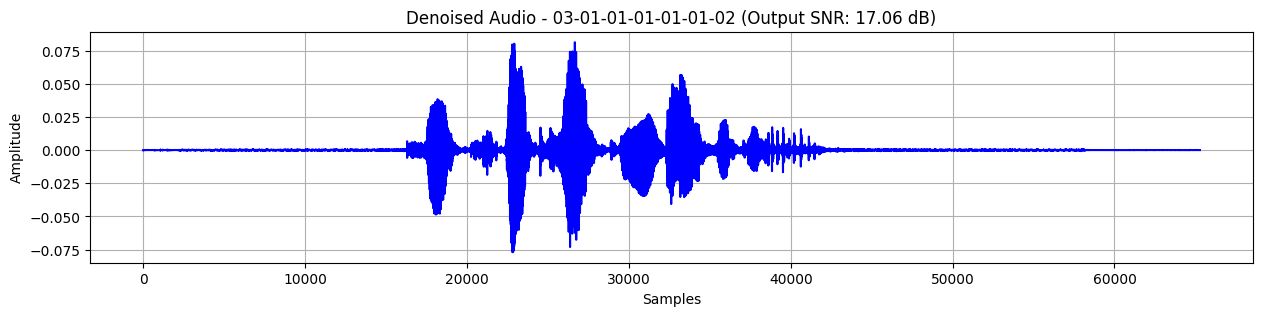

Saved enhanced audio: /kaggle/working/enhanced_audio/03-01-01-01-01-01-02_ambience_snr10dB_enhanced.wav

🔹 Sample 3: 03-01-01-01-01-01-02
Input SNR : -26.65 dB
Output SNR: 17.67 dB
SNR Improvement: 44.32 dB


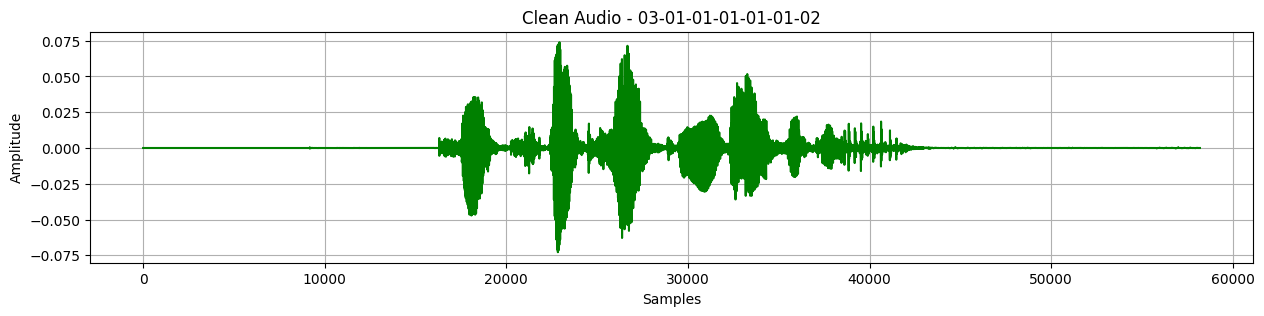

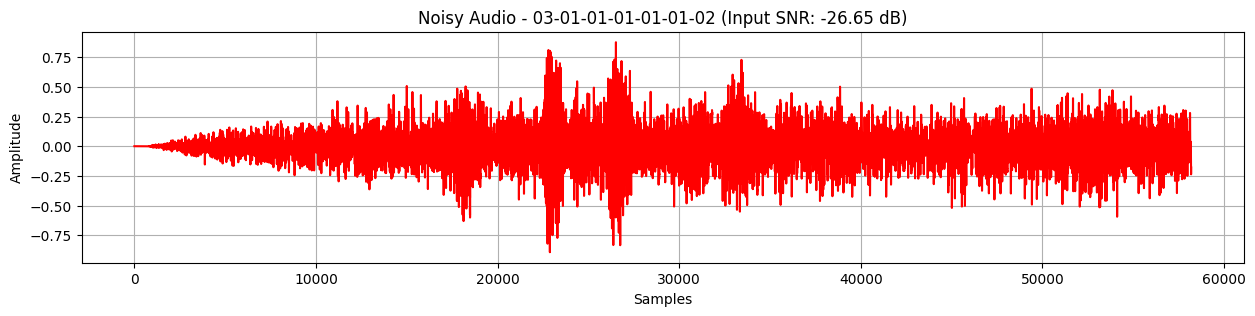

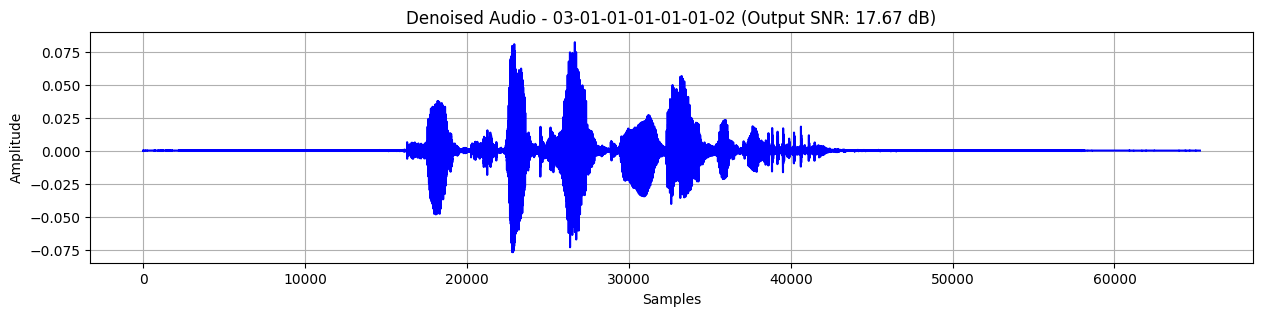

In [4]:
# =============================================
# COMPLETE RSUNet SPEECH DENOISING PIPELINE
# =============================================
# Author: Consolidated for Kaggle
# Dataset: Replace with your dataset path
# =============================================

import os
import numpy as np
import librosa
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
import re

# -------------------------------
# 1. ENVIRONMENT
# -------------------------------
print("Setting up environment...")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# -------------------------------
# 2. PATHS
# -------------------------------
dataset_name = "dataset-imp"  # CHANGE if needed
clean_dir = f"/kaggle/input/{dataset_name}/clean_wav/clean_wav"
noise_dir = f"/kaggle/input/{dataset_name}/noise_wav/noise_wav"

mix_dir = "/kaggle/working/mixed_snr_wav"
output_root = "/kaggle/working/dataset"
enhanced_dir = "/kaggle/working/enhanced_audio"

os.makedirs(mix_dir, exist_ok=True)
os.makedirs(output_root, exist_ok=True)
os.makedirs(os.path.join(output_root, "noisy_mag"), exist_ok=True)
os.makedirs(os.path.join(output_root, "clean_mag"), exist_ok=True)
os.makedirs(os.path.join(output_root, "phase"), exist_ok=True)
os.makedirs(enhanced_dir, exist_ok=True)

# -------------------------------
# 3. SNR MIXING FUNCTIONS (Corrected)
# -------------------------------
# -------------------------------
# CORRECTED SNR MIXING FUNCTIONS
# -------------------------------

def calculate_rms(audio):
    """Calculate RMS of audio signal"""
    return np.sqrt(np.mean(audio**2))

def calculate_snr_db(clean, noise):
    """Calculate SNR in dB between clean and noise signals"""
    clean_power = np.mean(clean**2)
    noise_power = np.mean(noise**2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(clean_power / noise_power)

def mix_at_snr(clean, noise, target_snr_db):
    """Mix clean and noise at target SNR"""
    min_len = min(len(clean), len(noise))
    clean = clean[:min_len]
    noise = noise[:min_len]
    
    # Calculate current SNR
    current_snr = calculate_snr_db(clean, noise)
    
    # Calculate required noise scaling factor
    target_snr_linear = 10**(target_snr_db / 10)
    current_snr_linear = 10**(current_snr / 10) if current_snr != float('inf') else float('inf')
    
    if current_snr == float('inf'):
        # If noise is zero, scale to achieve target SNR
        clean_power = np.mean(clean**2)
        target_noise_power = clean_power / target_snr_linear
        noise_scaling = np.sqrt(target_noise_power) / (calculate_rms(noise) + 1e-8)
    else:
        # Scale noise to achieve target SNR
        noise_scaling = np.sqrt(current_snr_linear / target_snr_linear)
    
    scaled_noise = noise * noise_scaling
    mixed = clean + scaled_noise
    
    # Normalize to prevent clipping, but preserve SNR
    max_val = np.max(np.abs(mixed))
    if max_val > 1.0:
        mixed = mixed / max_val
        scaled_noise = scaled_noise / max_val
        clean = clean / max_val
    
    # Calculate actual SNR
    actual_snr = calculate_snr_db(clean, scaled_noise)
    
    return mixed, scaled_noise, actual_snr

def prepare_snr_mixes(clean_dir, noise_dir, mix_dir, snr_levels=[-5, 0, 5, 10], sr=16000):
    """Prepare SNR mixtures with correct SNR calculation"""
    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".wav")])
    noise_files = sorted([f for f in os.listdir(noise_dir) if f.endswith(".wav")])
    
    print(f"Processing {len(clean_files)} clean files and {len(noise_files)} noise files")
    
    for clean_file in tqdm(clean_files, desc="Mixing audio"):
        clean_path = os.path.join(clean_dir, clean_file)
        clean_audio, _ = librosa.load(clean_path, sr=sr)
        
        # Normalize clean audio to reasonable level
        clean_audio = clean_audio / (np.max(np.abs(clean_audio)) + 1e-8) * 0.8
        
        for noise_file in noise_files:
            noise_path = os.path.join(noise_dir, noise_file)
            noise_audio, _ = librosa.load(noise_path, sr=sr)
            
            # Normalize noise audio
            noise_audio = noise_audio / (np.max(np.abs(noise_audio)) + 1e-8)
            
            for snr_db in snr_levels:
                mixed_audio, scaled_noise, actual_snr = mix_at_snr(clean_audio, noise_audio, snr_db)
                
                mix_name = f"{clean_file[:-4]}_{noise_file[:-4]}_snr{snr_db}dB.wav"
                sf.write(os.path.join(mix_dir, mix_name), mixed_audio, sr)
                
                # Print debug info for first few files
                if clean_files.index(clean_file) < 2 and noise_files.index(noise_file) < 2:
                    print(f"Target SNR: {snr_db} dB, Actual SNR: {actual_snr:.2f} dB")
    
    print(f"Mixed files created: {len(os.listdir(mix_dir))}")
prepare_snr_mixes(clean_dir, noise_dir, mix_dir)

# Also update the SNR calculation function for evaluation:
def calculate_snr(clean, processed):
    """Calculate SNR between clean and processed audio"""
    min_len = min(len(clean), len(processed))
    clean, processed = clean[:min_len], processed[:min_len]
    
    # Calculate signal power (assuming clean is the desired signal)
    signal_power = np.mean(clean**2)
    
    # Calculate noise power (difference between clean and processed)
    noise = clean - processed
    noise_power = np.mean(noise**2)
    
    if noise_power == 0:
        return float('inf')
    
    return 10 * np.log10(signal_power / noise_power)

# -------------------------------
# 4. STFT DATASET PREPARATION
# -------------------------------
def prepare_stft_dataset(clean_dir, mixed_dir, output_root, sr=16000, n_fft=1024, hop_length=256):
    mixed_files = [f for f in os.listdir(mixed_dir) if f.endswith(".wav")]
    for f in tqdm(mixed_files, desc="Creating STFT"):
        base_clean_name = f.split("_")[0]
        clean_path = os.path.join(clean_dir, base_clean_name + ".wav")
        if not os.path.exists(clean_path):
            continue
        noisy, _ = librosa.load(os.path.join(mixed_dir, f), sr=sr)
        clean, _ = librosa.load(clean_path, sr=sr)
        min_len = min(len(noisy), len(clean))
        noisy, clean = noisy[:min_len], clean[:min_len]
        noisy_stft = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length)
        clean_stft = librosa.stft(clean, n_fft=n_fft, hop_length=hop_length)
        noisy_mag, clean_mag, phase = np.abs(noisy_stft), np.abs(clean_stft), np.angle(noisy_stft)
        base_name = f.replace(".wav","")
        np.save(os.path.join(output_root,"noisy_mag",f"{base_name}_noisy_mag.npy"), noisy_mag)
        np.save(os.path.join(output_root,"clean_mag",f"{base_name}_clean_mag.npy"), clean_mag)
        np.save(os.path.join(output_root,"phase",f"{base_name}_phase.npy"), phase)

prepare_stft_dataset(clean_dir, mix_dir, output_root)

# -------------------------------
# 5. DATASET CLASS
# -------------------------------
class SpeechDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, max_frames=256):
        self.noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.endswith(".npy")])
        self.clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".npy")])
        self.noisy_dir, self.clean_dir, self.max_frames = noisy_dir, clean_dir, max_frames
    def pad_or_crop(self, x):
        freq, time = x.shape
        if time < self.max_frames:
            pad = np.zeros((freq, self.max_frames - time))
            x = np.concatenate([x, pad], axis=1)
        else:
            x = x[:, :self.max_frames]
        return x
    def __len__(self): return len(self.noisy_files)
    def __getitem__(self, idx):
        noisy = np.load(os.path.join(self.noisy_dir, self.noisy_files[idx]))
        clean = np.load(os.path.join(self.clean_dir, self.clean_files[idx]))
        noisy, clean = self.pad_or_crop(noisy), self.pad_or_crop(clean)
        return torch.tensor(noisy).unsqueeze(0).float(), torch.tensor(clean).unsqueeze(0).float()

noisy_dir_stft = os.path.join(output_root,"noisy_mag")
clean_dir_stft = os.path.join(output_root,"clean_mag")
dataset = SpeechDataset(noisy_dir_stft, clean_dir_stft, max_frames=256)
n = len(dataset)
train_len = int(0.8*n)
val_len = int(0.1*n)
test_len = n - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset,[train_len,val_len,test_len])
train_dl = DataLoader(train_ds,batch_size=8,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=8)
test_dl = DataLoader(test_ds,batch_size=8)
print(f"Dataset: {train_len} train, {val_len} val, {test_len} test")

# -------------------------------
# 6. RSUNet MODEL
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c,3,padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c,out_c,3,padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.skip = nn.Conv2d(in_c,out_c,1) if in_c!=out_c else nn.Identity()
    def forward(self,x):
        residual = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return F.relu(x + residual)

class RSUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ResidualBlock(1,32)
        self.enc2 = ResidualBlock(32,64)
        self.enc3 = ResidualBlock(64,128)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = ResidualBlock(128,256)
        self.up3 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec3 = ResidualBlock(256,128)
        self.up2 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec2 = ResidualBlock(128,64)
        self.up1 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec1 = ResidualBlock(64,32)
        self.out_conv = nn.Conv2d(32,1,1)
    def crop_or_pad(self, src, target):
        diffY = target.size(2) - src.size(2)
        diffX = target.size(3) - src.size(3)
        return F.pad(src, [diffX//2,diffX-diffX//2,diffY//2,diffY-diffY//2])
    def forward(self,x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.up3(b); d3=self.crop_or_pad(d3,e3); d3=torch.cat([d3,e3],1); d3=self.dec3(d3)
        d2 = self.up2(d3); d2=self.crop_or_pad(d2,e2); d2=torch.cat([d2,e2],1); d2=self.dec2(d2)
        d1 = self.up1(d2); d1=self.crop_or_pad(d1,e1); d1=torch.cat([d1,e1],1); d1=self.dec1(d1)
        out = self.out_conv(d1)
        return out

# -------------------------------
# 7. TRAINING FUNCTION
# -------------------------------
def train_model(model, train_dl, val_dl, name, epochs=30, lr=1e-3, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf'); patience_counter=0
    train_losses, val_losses=[],[]
    for epoch in range(epochs):
        model.train(); train_loss=0
        for x,y in train_dl:
            x,y=x.to(device),y.to(device)
            optimizer.zero_grad(); pred=model(x)
            loss=criterion(pred,y); loss.backward(); optimizer.step()
            train_loss+=loss.item()
        model.eval(); val_loss=0
        with torch.no_grad():
            for x,y in val_dl:
                x,y=x.to(device),y.to(device)
                val_loss+=criterion(model(x),y).item()
        train_loss/=len(train_dl); val_loss/=len(val_dl)
        train_losses.append(train_loss); val_losses.append(val_loss)
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience_counter=0
            torch.save({'model_state_dict':model.state_dict()}, f"/kaggle/working/best_{name}.pth")
        else: patience_counter+=1
        if patience_counter>=patience: print(f"Early stopping at epoch {epoch+1}"); break
        if (epoch+1)%10==0: print(f"Epoch {epoch+1}: Train Loss {train_loss:.6f}, Val Loss {val_loss:.6f}")
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(train_losses,label='Train'); plt.plot(val_losses,label='Val')
    plt.title(f'{name} Training'); plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.grid(True)
    plt.savefig(f"/kaggle/working/training_history.png"); plt.close()
    return model

# -------------------------------
# 8. TRAIN RSUNet
# -------------------------------
rsunet_model = RSUNet()
rsunet_model = train_model(rsunet_model, train_dl, val_dl, "rsunet")

# -------------------------------
# 9. TEST EVALUATION & AUDIO RECONSTRUCTION
# -------------------------------
def reconstruct_audio(model, noisy_mag_path, phase_path, output_dir, sr=16000, max_frames=256):
    os.makedirs(output_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(device); model.eval()
    noisy_mag = np.load(noisy_mag_path)
    phase = np.load(phase_path)
    freq,time = noisy_mag.shape
    if time<max_frames: noisy_mag_input=np.concatenate([noisy_mag,np.zeros((freq,max_frames-time))],axis=1)
    else: noisy_mag_input=noisy_mag[:,:max_frames]
    noisy_tensor=torch.tensor(noisy_mag_input).unsqueeze(0).unsqueeze(0).float().to(device)
    with torch.no_grad(): enhanced_mag=model(noisy_tensor).cpu().squeeze().numpy()
    freq_mag,time_mag = enhanced_mag.shape
    freq_phase,time_phase=phase.shape
    if time_phase<time_mag: phase_aligned=np.concatenate([phase,np.zeros((freq_phase,time_mag-time_phase))],axis=1)
    else: phase_aligned=phase[:,:time_mag]
    enhanced_stft=enhanced_mag*np.exp(1j*phase_aligned)
    enhanced_audio=librosa.istft(enhanced_stft)
    output_path=os.path.join(output_dir, os.path.basename(noisy_mag_path).replace("_noisy_mag.npy","_enhanced.wav"))
    sf.write(output_path, enhanced_audio, sr)
    print(f"Saved enhanced audio: {output_path}")
    return output_path

def calculate_snr(clean, processed):
    min_len = min(len(clean), len(processed))
    clean, processed = clean[:min_len], processed[:min_len]
    noise = clean - processed
    return 10*np.log10(np.sum(clean**2)/(np.sum(noise**2)+1e-8))

def plot_waveform(waveform, label, color='blue', sr=16000):
    plt.figure(figsize=(15,3)); plt.plot(waveform,color=color)
    plt.title(label); plt.xlabel("Samples"); plt.ylabel("Amplitude"); plt.grid(True); plt.show()

def play_audio(waveform, sr=16000): return ipd.Audio(waveform, rate=sr)

# Process first 3 test samples
test_noisy_files = sorted(os.listdir(noisy_dir_stft))[:3]
for idx,test_noisy_file in enumerate(test_noisy_files):
    clean_id_match = re.match(r'^(\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2})', test_noisy_file)
    if not clean_id_match: continue
    clean_id = clean_id_match.group(1)
    clean_wav_file = os.path.join(clean_dir, clean_id+".wav")
    noisy_wav_file = os.path.join(mix_dir, [f for f in os.listdir(mix_dir) if f.startswith(clean_id)][0])
    phase_path = os.path.join(output_root,"phase",[f for f in os.listdir(os.path.join(output_root,"phase")) if f.startswith(clean_id)][0])
    enhanced_wav_file = reconstruct_audio(rsunet_model, os.path.join(noisy_dir_stft,test_noisy_file), phase_path, enhanced_dir)
    clean, _ = librosa.load(clean_wav_file, sr=16000)
    noisy, _ = librosa.load(noisy_wav_file, sr=16000)
    enhanced, _ = librosa.load(enhanced_wav_file, sr=16000)
    input_snr = calculate_snr(clean, noisy)
    output_snr = calculate_snr(clean, enhanced)
    print(f"\n🔹 Sample {idx+1}: {clean_id}")
    print(f"Input SNR : {input_snr:.2f} dB")
    print(f"Output SNR: {output_snr:.2f} dB")
    print(f"SNR Improvement: {output_snr-input_snr:.2f} dB")
    plot_waveform(clean,f"Clean Audio - {clean_id}",color='green'); display(play_audio(clean))
    plot_waveform(noisy,f"Noisy Audio - {clean_id} (Input SNR: {input_snr:.2f} dB)",color='red'); display(play_audio(noisy))
    plot_waveform(enhanced,f"Denoised Audio - {clean_id} (Output SNR: {output_snr:.2f} dB)",color='blue'); display(play_audio(enhanced))
